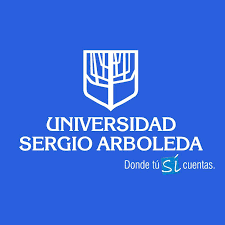

###**Integrantes**
* Daniel Velasquez
* Laura Ojeda

#**Bibliotecas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import re
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML
import gdown

#**Cargar base de datos**


Metodo para verificar si se ha importado ya la base de datos

In [ ]:
def verificar_archivo(url, nombre_archivo):
  contenido = os.listdir()
  if nombre_archivo not in contenido:
    gdown.download(url, nombre_archivo, quiet=False)
    !unzip data.zip

In [ ]:
url = 'https://drive.google.com/uc?id=1o976PmREPBiXqdVTpgXxD-1oxNHTA5V_'
nombre_archivo = 'data.zip'
verificar_archivo(url, nombre_archivo)

#**Metodos de extracción y visualización de datos**

## **Extracción**

Metodo para unificar los datos de los pacientes

In [ ]:
def combine_patient_data(patient_id, directory):
  data = {}
  for file_type in ['Breaths', 'Fix', 'Numerics', 'Signals']:
    filename = f"bidmc_{patient_id}_{file_type}"
    if file_type == 'Fix':
      data[file_type] = pd.read_csv(os.path.join(directory, f"{filename}.txt"), sep='\t')
    else:
      data[file_type] = pd.read_csv(os.path.join(directory, f"{filename}.csv"))
  return data

Metodo para extraer la edad y genero del archivo Fix.txt

In [ ]:
def extract_age_gender(fix_data):
    age = None
    gender = None

    for index, row in fix_data.iterrows():
        for item in row:
            match_age = re.match(r'Age:\s*(\d+)', item)
            match_gender = re.match(r'Gender:\s*(\w)', item)
            if match_age:
                age = match_age.group(1)
            elif match_gender:
                gender = match_gender.group(1)

    return age, gender

Metodo para extraer el número del paciente del nombre del archivo

In [ ]:
def extract_patient_number(filename):
    return filename.split("_")[1]

Metodo para recorrer los archivos Fix.txt y Numerics.csv y almacenarlos en listas

In [ ]:
def almac_files():
  # Lista para almacenar los nombres de los archivos Fix.txt y Numerics.csv
  fix_files = []
  numeric_files = []

  # Recorre todos los archivos en el directorio y almacena los nombres de archivos Fix.txt y Numerics.csv
  for filename in os.listdir(directory):
      if filename.endswith("Fix.txt"):
          fix_files.append(filename)
      if filename.endswith("Numerics.csv"):
          numeric_files.append(filename)

  # Ordenar la lista de nombres de archivo Fix.txt por el número de paciente
  fix_files.sort(key=lambda x: extract_patient_number(x))

  # Ordenar la lista de nombres de archivo numérico por el número de paciente
  numeric_files.sort(key=lambda x: extract_patient_number(x))
  return fix_files, numeric_files

Metodo para extraer la edad y genero de cada paciente, generando la clasificacion tanto individual como en conjunto

In [ ]:
def process_patient_files(directory, modo):
  fix_files, numeric_files = almac_files()

  # Diccionario donde se almacenaran el numero de clasificaciones de pacientes
  classification_count = {}
  # Diccionario para almacenaran la información de cada uno de los pacientes
  patients_info = {}

  for fix_filename, numeric_filename in zip(fix_files, numeric_files):
      # Extrae el número del paciente del archivo Fix.txt
      patient_number = extract_patient_number(fix_filename)

      # Fix.txt se abre para obtener la información adicional como edad y género
      with open(os.path.join(directory, fix_filename), 'r') as file:
          lines = file.readlines()
          # Busca la linea que contiene la data de edad
          age_line = next((line for line in lines if line.startswith('Age')), None)
          # Busca la línea que contiene la data de género
          gender_line = next((line for line in lines if line.startswith('Gender')), None)
          if age_line is None or gender_line is None:
              print(f"No se pudo encontrar información de edad o género en el archivo {fix_filename}.")
              continue
          # Extraer la edad del paciente
          age_str = age_line.split(': ')[1].strip()
          # Establecer un valor comun a aquellos registros que indican a pacientes de mas de 90 años para facilidad del procesado de informacion
          if age_str == '90+':
              age = 90
          else:
              try:
                  age = int(age_str)
              except ValueError:
                  print(f"Valor no válido para la edad en el archivo {fix_filename}: {age_str}")
                  continue
          # Extraer el genero del paciente
          gender = gender_line.split(': ')[1].strip()

      # Se lee el archivo numerics.csv de cada paciente y se clasifica
      numerics_filepath = os.path.join(directory, numeric_filename)
      try:
          patient_data = pd.read_csv(numerics_filepath)
      except FileNotFoundError:
          print(f"No se pudo encontrar el archivo {numeric_filename}.")
          continue
      if modo == 1:
        classification, _ = classify_patient(patient_data, patient_number, age, gender)

        # Agregar al diccionario de recuento de clasificaciones
        if classification in classification_count:
            classification_count[classification] += 1
        else:
            classification_count[classification] = 1
      else:
        classification, physiological_data = classify_patient(patient_data, patient_number, age, gender)
        # Agregar la información del paciente al diccionario
        patients_info[patient_number] = {
          'age': age,
          'gender': gender,
          'Physiological Data': physiological_data,
          'classification': classification
        }
  if modo == 1:
    return classification_count
  else:
    return patients_info

Metodo para extraer en un Dataframe la informacion de edad y genero de cada paciente

In [ ]:
def extract_df_gender_age():
  ages = []
  genders = []
  for file in os.listdir(directory):
    if file.endswith("_Fix.txt"):
      patient_id = file.split('_')[1]
      fix_path = os.path.join(directory, file)
      with open(fix_path, 'r') as f:
          fix_content = f.readlines()
      fix_data = pd.DataFrame({'bidmc_01': fix_content})
      sub_df = fix_data.iloc[:7]
      age, gender = extract_age_gender(sub_df)
      ages.append(age)
      genders.append(gender)
  return ages, genders

Metodo para limpiar y preprocesar el Dataframe de edad y genero

In [ ]:
def limpieza_df(df_age_gender):
  df_age_gender['Age'] = pd.to_numeric(df_age_gender['Age'], errors='coerce')
  age_mean = round(df_age_gender['Age'].mean())
  gender_mode = df_age_gender['Gender'].mode()[0]
  df_age_gender['Age'].fillna(age_mean, inplace=True)
  df_age_gender['Gender'].fillna(gender_mode, inplace=True)
  df_age_gender['Age'] = df_age_gender['Age'].astype(int)

Metodo para extraccion de diagnostico en texto

In [ ]:
def physiological_data_analisis(data):
  texto = ""
  for key, value in data.items():
      extract = re.sub(' ', '', re.sub(r'\([^)]*\)', '', key)) + ":" + value.get('Diagnostico')
      texto += extract + ", "
  # Elimina la última coma y espacio sobrantes
  if texto.endswith(", "):
      texto = texto[:-2]
  return texto

## **Visualizacion**

Metodo para visualizar las tablas de Breaths, Fix, Numerics y Signals de cada paciente

In [ ]:
def visualize_patient_data(patient_data):
    print("Breaths Data:")
    print(patient_data['Breaths'].head())
    print()
    print("Fix Data:")
    print(patient_data['Fix'].head())
    print()
    print("Numerics Data:")
    print(patient_data['Numerics'].head())
    print()
    print("Signals Data:")
    print(patient_data['Signals'].head())
    print()

Metodo para visualizar cada tabla de cada paciente

In [ ]:
def explore_and_visualize_patient_data(patient_id, directory):
    patient_data = combine_patient_data(patient_id, directory)

    print("\nVisualización de los datos del paciente:")
    visualize_patient_data(patient_data)

    print("\nDescripción de las señales de respiración manuales:")
    print(patient_data['Breaths'].describe())

    print(f"\nVisualización de los parámetros fisiológicos: {patient_id}\n")
    plot_numerics_data(patient_data['Numerics'])
    print("\nDescripción de los datos numéricos:")
    print(patient_data['Numerics'].describe())

    print(f"\nVisualización de las señales fisiológicas del paciente: {patient_id}\n")
    plot_individual_signals(patient_data['Signals'])
    print("\nDescripción de las señales fisiológicas:")
    print(patient_data['Signals'].describe().to_string(index=False))

    return patient_data['Numerics']

Metodo para graficar la distribucion de la informacion

In [ ]:
def plot_data_distributions(combined_data, columns_to_plot_numerics=11, columns_to_plot_signals=11):
  sns.set_style('whitegrid')
  fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

  palette = sns.color_palette("deep")
  sns.set_palette(palette)

  # Tabla Numerics
  for i, column in enumerate(combined_data['Numerics'].columns[:columns_to_plot_numerics]):
    sns.histplot(data=combined_data['Numerics'], x=column, kde=True, legend=True, ax=axs[i // 4, i % 4])
    axs[i // 4, i % 4].set_title(f"Distribucion de {column} en Numerics", fontsize=10)
    axs[i // 4, i % 4].tick_params(bottom=False, labelsize=8)

  # Tabla Signals
  start_index = len(combined_data['Numerics'].columns[:columns_to_plot_numerics])
  for i, column in enumerate(combined_data['Signals'].columns[:columns_to_plot_signals]):
    sns.histplot(data=combined_data['Signals'], x=column, kde=True, legend=True, ax=axs[(i // 4) + 1, i % 4])
    axs[(i // 4) + 1, i % 4].set_title(f"Distribucion de {column} en Signals", fontsize=10)
    axs[(i // 4) + 1, i % 4].tick_params(bottom=False, labelsize=8)

  plt.tight_layout()

  plt.show()

Metodo patra graficar la informacion del archivo Numerics.csv de cada paciente

In [ ]:
def plot_numerics_data(numerics_data):
    colors = ['red', 'blue', 'green', 'orange']

    plt.figure(figsize=(16, 8))
    for i, signal in enumerate([' HR', ' PULSE', ' RESP', ' SpO2']):
        plt.plot(numerics_data['Time [s]'], numerics_data[signal], label=signal, color=colors[i])

    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.title('Señales Fisiologicas')
    plt.xlim(0, 480)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    for signal, color in zip([' HR', ' PULSE', ' RESP', ' SpO2'], colors):
        plt.figure(figsize=(12, 4))
        plt.plot(numerics_data['Time [s]'], numerics_data[signal], color=color)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Valor')
        plt.title(f'{signal} Señal')
        plt.xlim(0, 480)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Metodo para graficar las señales de cada paciente

In [ ]:
def plot_individual_signals(signals_data):
    for col in signals_data.columns[1:]:
        plt.figure(figsize=(15, 4))
        plt.plot(signals_data['Time [s]'], signals_data[col])
        plt.xlabel('Tiempo [s]')
        plt.ylabel(col)
        plt.title(f'{col} Señal')
        plt.xlim(0, 7)
        plt.grid(True)
        plt.show()
        print('\n')

Metodo para visualizar el numero de filas de cada tabla

In [ ]:
def vis_num_filas(combined_data):
  filas = []
  num_filas = []

  for df_name, df in combined_data.items():
    filas.append(df_name)
    num_filas.append(len(df))

  plt.figure(figsize=(10, 6))
  bars = plt.bar(filas, num_filas, color='skyblue')
  for bar, num in zip(bars, num_filas):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, num, ha='center', va='bottom')

  plt.title('Número de filas por DataFrame')
  plt.xlabel('DataFrame')
  plt.ylabel('Número de filas')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

## **Clasificacion según diagnosticos**

Signos vitales:

* Frecuencia cardíaca (HR):
  * La frecuencia cardíaca es el número de veces que el corazón late en un minuto. Se mide en latidos por minuto (bpm). Es un indicador crucial de la salud cardiovascular y puede variar en respuesta a factores como la actividad física, el estrés, la temperatura corporal y la salud general del individuo.
  * El rango normal de la frecuencia cardíaca en reposo para adultos oscila entre 60 y 100 latidos por minuto (bpm). Sin embargo, esto puede variar según la edad, la condición física y otros factores individuales.

* Pulso (PULSE):
  * El pulso es una medida de la expansión y contracción rítmica de las arterias debido al bombeo de sangre desde el corazón. El pulso se siente como un latido y se puede medir en diferentes puntos del cuerpo donde las arterias están cerca de la superficie de la piel, como la muñeca, el cuello o la ingle. Normalmente, el pulso coincide con la frecuencia cardíaca y se expresa en latidos por minuto (bpm).
  * El pulso normalmente coincide con la frecuencia cardíaca y, por lo tanto, también cae dentro del rango de 60 a 100 bpm para adultos en reposo.

* Frecuencia respiratoria (RESP):
  * La frecuencia respiratoria es el número de respiraciones que una persona toma en un minuto. Se mide contando el número de inhalaciones y exhalaciones completas. La frecuencia respiratoria puede aumentar en respuesta al ejercicio, la ansiedad, la fiebre, el dolor u otras condiciones médicas. Es un indicador importante de la función pulmonar y puede ser útil para evaluar la salud respiratoria.
  * La frecuencia respiratoria normal en reposo para adultos es típicamente de 12 a 20 respiraciones por minuto.

* Saturación de oxígeno (SpO2):
  * La saturación de oxígeno es una medida de la cantidad de oxígeno transportada por los glóbulos rojos en la sangre. Se expresa como un porcentaje y se mide típicamente mediante un dispositivo llamado oxímetro de pulso, que se coloca en un dedo u otra parte del cuerpo. Una saturación de oxígeno del 95% o superior se considera normal en personas sanas, mientras que valores inferiores pueden indicar hipoxemia, una condición en la que hay niveles bajos de oxígeno en la sangre, lo que puede ser preocupante y requerir atención médica.
  * La saturación de oxígeno normal en sangre arterial (SpO2) en personas sanas es generalmente del 95% o superior. Valores por debajo de 90% pueden indicar hipoxemia (niveles bajos de oxígeno en la sangre).

Clasificacion de signos vitales segun su rango:
* Frecuencia cardíaca (HR):
  * Por debajo de 60 bpm: Bradicardia (ritmo cardíaco lento). Puede ser normal en personas bien entrenadas físicamente, pero también puede indicar problemas cardíacos o condiciones como hipotiroidismo.
  * Entre 60 y 100 bpm: Rango normal en reposo para adultos.
  * Por encima de 100 bpm: Taquicardia (ritmo cardíaco rápido). Puede ser causada por ejercicio, estrés, fiebre, deshidratación u otras condiciones médicas.

* Pulso (PULSE):
  * Los mismos rangos que la frecuencia cardíaca se aplican al pulso, ya que generalmente coinciden.

* Frecuencia respiratoria (RESP):
  * Por debajo de 12 respiraciones por minuto: Bradipnea (respiración lenta). Puede ser normal en personas que están profundamente relajadas o durmiendo, pero también puede indicar problemas respiratorios o neurológicos.
  * Entre 12 y 20 respiraciones por minuto: Rango normal en reposo para adultos.
  * Por encima de 20 respiraciones por minuto: Taquipnea (respiración rápida). Puede ser causada por ejercicio, ansiedad, fiebre, dolor, problemas pulmonares o cardíacos, entre otros.

* Saturación de oxígeno (SpO2):
  * Por debajo de 90%: Hipoxemia (niveles bajos de oxígeno en la sangre). Puede ser un signo de problemas respiratorios graves, como neumonía, enfermedad pulmonar obstructiva crónica (EPOC) o insuficiencia cardíaca.
  * Entre 90% o superior: Considerado normal en personas sanas.



In [ ]:
def det_rangos_normales(dato, val):
  clasi = ""
  min = 0
  max = 0
  rango = None
  rangos_normales = [
      ['HR', 60, 100, ['Bradicardia (ritmo cardíaco lento)', 'Rango normal', 'Taquicardia (ritmo cardíaco rápido)'] ],
      ['PULSE', 60, 100, ['Lento', 'Normal', 'Rapido'] ],
      ['RESP', 12, 20, ['Bradipnea (respiración lenta)', 'Rango normal', 'Taquipnea (respiración rápida)'] ],
      ['SpO2', 90, 100, ['Hipoxemia (niveles bajos de oxígeno en la sangre)', 'Rango normal', 'Rango elevado'] ]
  ]

  for item in rangos_normales:
        if item[0] == dato:
            rango = item
  min = rango[1]
  max = rango[2]
  clasificacion = rango[3]

  if val >= min and val <= max:
    clasi = clasificacion[1]
  elif val < min:
    clasi = clasificacion[0]
  elif val > max:
    clasi = clasificacion[2]
  return clasi

In [ ]:
def classify_patient(patient_data, patient_id, age, gender):
  valores = patient_data.mean().round(2)

  dato_HR = det_rangos_normales('HR', valores[' HR'])
  dato_PULSE = det_rangos_normales('PULSE', valores[' PULSE'])
  dato_RESP = det_rangos_normales('RESP', valores[' RESP'])
  dato_SpO2 = det_rangos_normales('SpO2', valores[' SpO2'])

  print("")
  print("-------------------------------------")
  print(f"Datos del paciente {patient_id}:")
  print(f" * Edad: {age}")
  print(f" * Género: {gender}")
  print(f" * Promedio de variables fisiológicas:")
  print(f"   -> HR (Frecuencia Cardíaca): {valores[' HR']} = {dato_HR}")
  print(f"   -> PULSE (Pulso): {valores[' PULSE']} = {dato_PULSE}")
  print(f"   -> RESP (Respiración): {valores[' RESP']} = {dato_RESP}")
  print(f"   -> SpO2 (Saturación de Oxígeno): {valores[' SpO2']} = {dato_SpO2}")

  tipo = "HR:" + dato_HR + ", PULSE:" + dato_PULSE + ", RESP:" + dato_RESP + ", SpO2:" + dato_SpO2

  print(f"Diagnóstico médico del paciente {patient_id}: {tipo}")

  physiological_data = {
      'HR (Frecuencia Cardíaca)': {
          'Valor promedio': valores[' HR'],
          'Diagnostico': dato_HR
      },
      'PULSE (Pulso)': {
          'Valor promedio': valores[' PULSE'],
          'Diagnostico': dato_PULSE
      },
      'RESP (Respiración)': {
          'Valor promedio': valores[' RESP'],
          'Diagnostico': dato_RESP
      },
      'SpO2 (Saturación de Oxígeno)': {
          'Valor promedio': valores[' SpO2'],
          'Diagnostico': dato_SpO2
      }
  }
  return tipo, physiological_data

##**Visualizacion HTML**

In [ ]:
def clasificacion_html(data):
  html = """
  <html>
  <head>
      <style>
          body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                color: #333;
          }
          h2 {
              color: #eea4bb;
              text-align: center;
          }
          table {
              width: 100%;
              border-collapse: collapse;
              margin-top: 20px;
          }
          th, td {
              padding: 12px;
              text-align: center;
              border-bottom: 1px solid #ddd;
          }
          th {
              background-color: #d1a777;
              color: white;
          }
          tr:nth-child(even) {
              background-color: #f2f2f2;
          }
          .container {
              max-width: 800px;
              margin: 0 auto;
          }
          .centered {
              text-align: center;
          }
      </style>
  </head>
  <body>
      <div class='container'>
          <h2>Información de los pacientes del dataset</h2>
          <table>
              <tbody>"""

  for key, value in data.items():
      html += f"""
                  <tr>
                      <td colspan='2'><b>{key}</b></td>
                  """
      if isinstance(value, dict):
          for k, v in value.items():
              html += f"""
                  <tr>
                      <td>{k}</td>
                      <td>{v}</td>
                  </tr>"""
      else:
          html += f"""
                      <td colspan='2'>{value}</td>
                  </tr>"""

  html += """
              </tbody>
          </table>
      </div>
  </body>
  </html>"""

  return html

In [ ]:
def patient_htlm(patient_data, patient_id):
  if patient_id not in patient_data:
      return "<html><body><h2>No se encontraron datos para este paciente.</h2></body></html>"

  age = patient_data[patient_id]["age"]
  gender = patient_data[patient_id]["gender"]
  diagnosis = patient_data[patient_id]["classification"]
  physiological_data = patient_data[patient_id]["Physiological Data"]

  html = """
  <html>
    <head>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                color: #333;
            }
            h2 {
                color: #eea4bb;
                text-align: center;
            }
            table {
                width: 100%;
                border-collapse: collapse;
                margin-top: 20px;
            }
            th, td {
                padding: 12px;
                text-align: center;
                border-bottom: 1px solid #ddd;
            }
            th {
                background-color: #d1a777;
                color: white;
            }
            tr:nth-child(even) {
                background-color: #f2f2f2;
            }
            .container {
                max-width: 800px;
                margin: 0 auto;
            }
            .centered {
                text-align: center;
            }
        </style>
    </head>"""

  html += f"""
    <body>
        <div class='container'>
            <h2>PACIENTE {patient_id}:</h2>
            <table>
                <tr>
                    <td colspan='3' class='centered' style='background-color: #86dcaa;'>Información General</td>
                </tr>
                <tr>
                    <td class='centered' colspan='2'>Edad:</td>
                    <td>{age}</td>
                </tr>
                <tr>
                    <td class='centered' colspan='2'>Género:</td>
                    <td>{gender}</td>
                </tr>
                <tr>
                    <th colspan='3'>Valores fisiologicos</th>
                </tr>
                <tr>
                    <th>Variable</th>
                    <th>Valor Promedio</th>
                    <th>Clasificación</th>
                </tr>"""

  for key, value in physiological_data.items():
      value_promedio = value['Valor promedio']
      diagnostico = value['Diagnostico']
      html += f"""
              <tr>
                  <td>{key}</td>
                  <td>{value_promedio}</td>
                  <td>({diagnostico})</td>
              </tr>"""

  html += f"""
              <tr>
                  <th colspan='3'>Diagnóstico:</th>
              </tr>
              <tr>
                  <td colspan='3'>{diagnosis}</td>
              </tr>
          </table>
      </div>
  </body>
  </html>"""

  return html

In [ ]:
def gen_patient_id_html(classification_results):
  patient_id = input("Ingrese el número del paciente: ")
  html_content = patient_htlm(classification_results, patient_id)
  with open(f"/content/html_data/patient_{patient_id}_info.html", "w") as file:
      file.write(html_content)
  return html_content

#**Análisis**

In [ ]:
directory = '/content/bidmc_csv'

In [ ]:
combined_data = combine_patient_data(10, directory)
print("DESCRIPCION DE CADA TIPO DE TABLA\n\n")
for file_type, df in combined_data.items():
  print("")
  print("-" * 80)
  print(f"Tabla: {file_type}")
  print("-" * 80)
  print("Información:")
  print("")
  print(df.info())

DESCRIPCION DE CADA TIPO DE TABLA



--------------------------------------------------------------------------------
Tabla: Breaths
--------------------------------------------------------------------------------
Información:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   breaths ann1 [signal sample no]   146 non-null    float64
 1    breaths ann2 [signal sample no]  152 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.5 KB
None

--------------------------------------------------------------------------------
Tabla: Fix
--------------------------------------------------------------------------------
Información:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  --

Visualizacion de la distribucion de la informacion en cada tabla

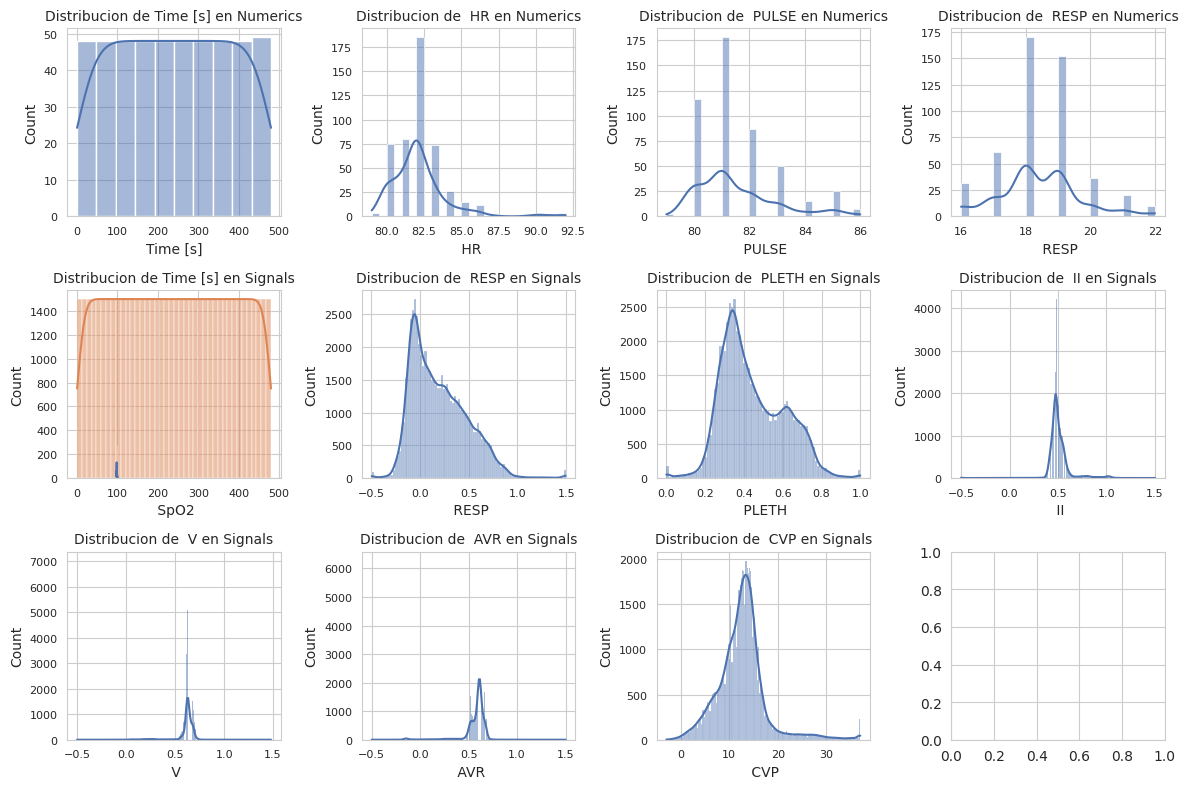

In [ ]:
plot_data_distributions(combined_data)

Visualizacion de numero de tablas por tabla

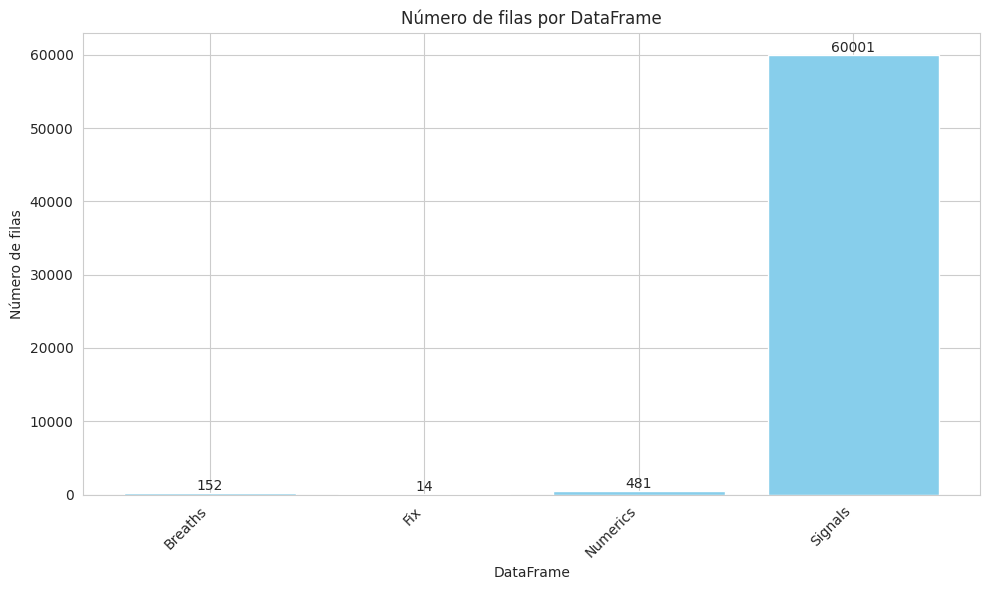

In [ ]:
vis_num_filas(combined_data)

#**Pacientes**

##**Procesamiento de información**

In [ ]:
ages, genders = extract_df_gender_age()
df_age_gender = pd.DataFrame({'Age': ages, 'Gender': genders})

In [ ]:
df_age_gender.describe()

,Age,Gender
count,52,52
unique,32,2
top,44,F
freq,4,32


In [ ]:
limpieza_df(df_age_gender)

## **Visualización de genero y edad**

###**Distribución de edad por género**

####**Diagrama de barras**

In [ ]:
colors = ['purple', 'green']

In [ ]:
# Recuento de pacientes por género y edad
genders_by_age = df_age_gender.groupby(['Gender', 'Age']).size().unstack(fill_value=0)
fig = go.Figure()
bar_width = 0.8
fig.add_trace(go.Bar(name='M', x=genders_by_age.columns, y=genders_by_age.loc['M'], marker_color=colors[1], width=bar_width))
fig.add_trace(go.Bar(name='F', x=genders_by_age.columns, y=genders_by_age.loc['F'], marker_color=colors[0], width=bar_width, base=genders_by_age.loc['M']))
fig.update_layout(barmode='relative', title='Distribución de Edad por Género', xaxis_title='Edad', yaxis_title='Número de Pacientes')
fig.show()

####**Diagrama de violin**

In [ ]:
data = df_age_gender[['Gender', 'Age']]
color_map = {'M': 'green', 'F': 'purple'}
fig = go.Figure()
for gender in data['Gender'].unique():
    if gender in color_map:
        ages = data[data['Gender'] == gender]['Age']
        fig.add_trace(go.Violin(y=ages, name=gender, marker_color=color_map[gender]))
fig.update_layout(title='Distribución de Edad por Género', xaxis_title='Género', yaxis_title='Edad')
fig.show()

* El diagrama de violin se comporta como un espejo
* Obeservamos que en las partes anchas son donde se concentra gran cantidad de poblacion
* Concentracion en valores bajos

###**Diagrama de pastel por género**

In [ ]:
gender_counts = df_age_gender['Gender'].value_counts()
fig = go.Figure(data=[go.Pie(labels=gender_counts.index, values=gender_counts.values, marker=dict(colors=colors))])
fig.update_layout(title='Distribución de Género de Pacientes')
fig.show()

#**Información médica de los pacientes por numero de id**

##**Visualización**

Ingrese el número del paciente: 10

Visualización de los datos del paciente:
Breaths Data:
   breaths ann1 [signal sample no]   breaths ann2 [signal sample no]
0                            293.0                               293
1                            663.0                               689
2                           1015.0                              1042
3                           1346.0                              1322
4                           1672.0                              1644

Fix Data:
                                bidmc_10
0  Signals: RESP; PLETH; II; V; AVR; CVP
1     Signals sampling frequency: 125 Hz
2        Numerics: HR; PULSE; RESP; SpO2
3      Numerics sampling frequency: 1 Hz
4                                Age: 74

Numerics Data:
   Time [s]   HR   PULSE   RESP   SpO2
0         0   85      83     21     98
1         1   85      83     21     99
2         2   85      85     20     99
3         3   85      85     20     99
4         4   86      85   

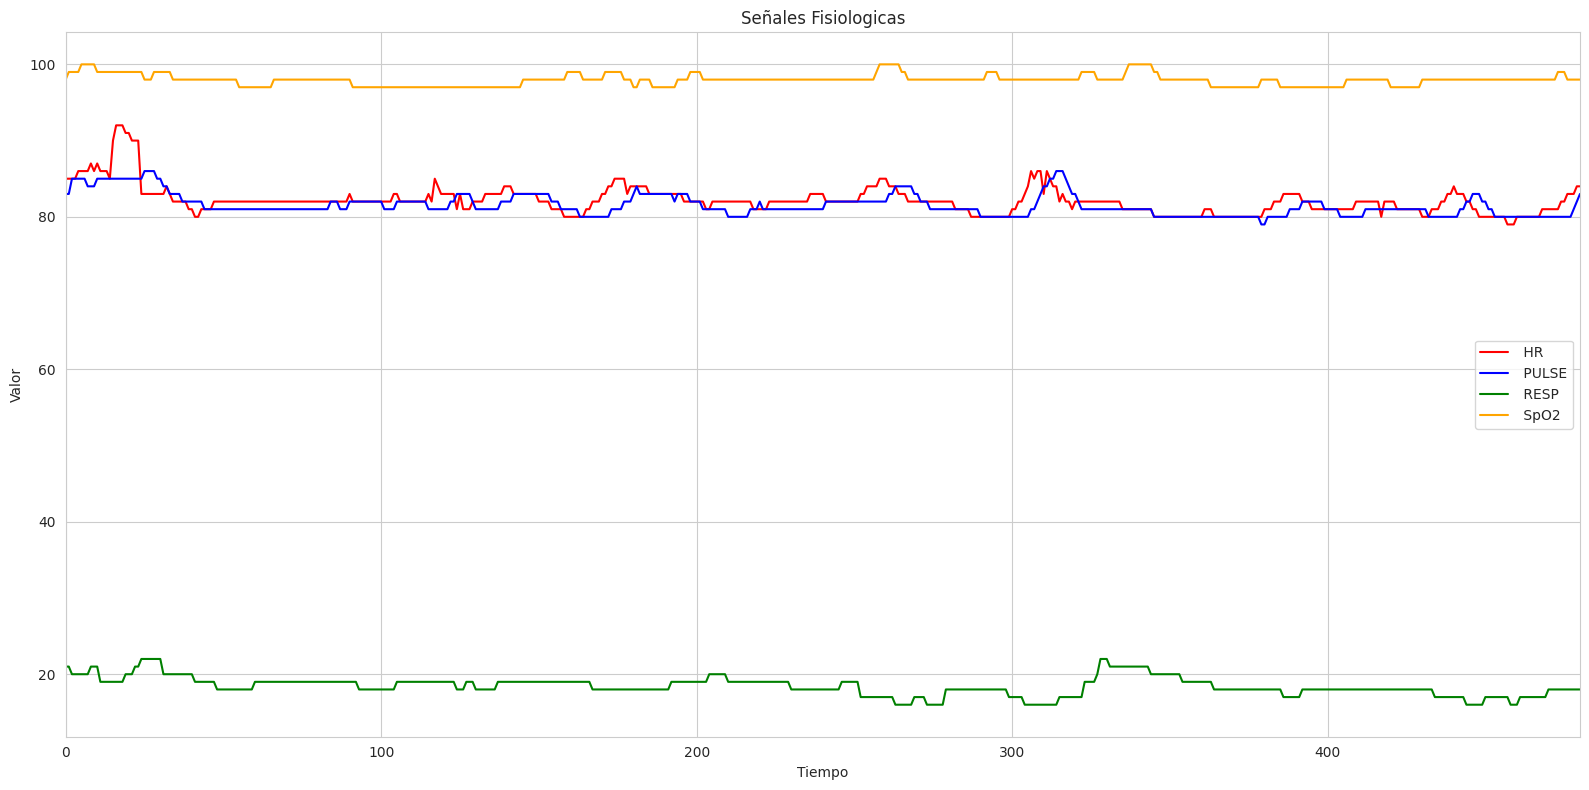

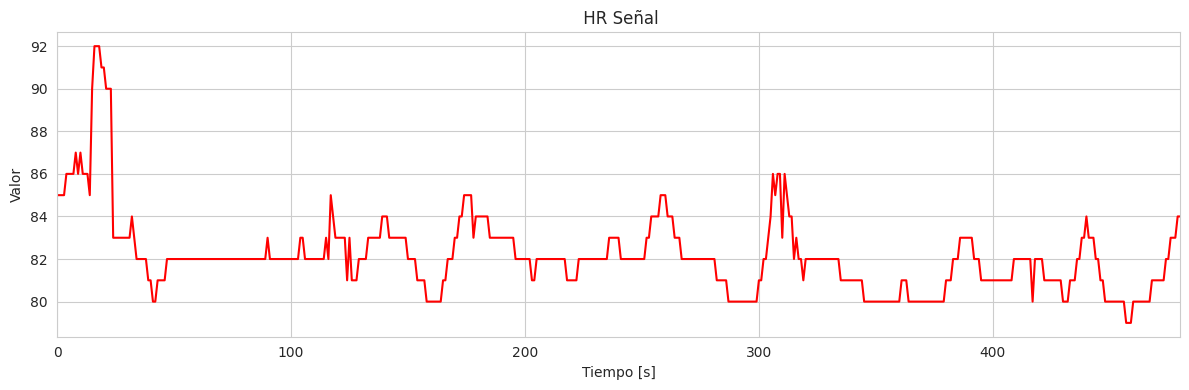

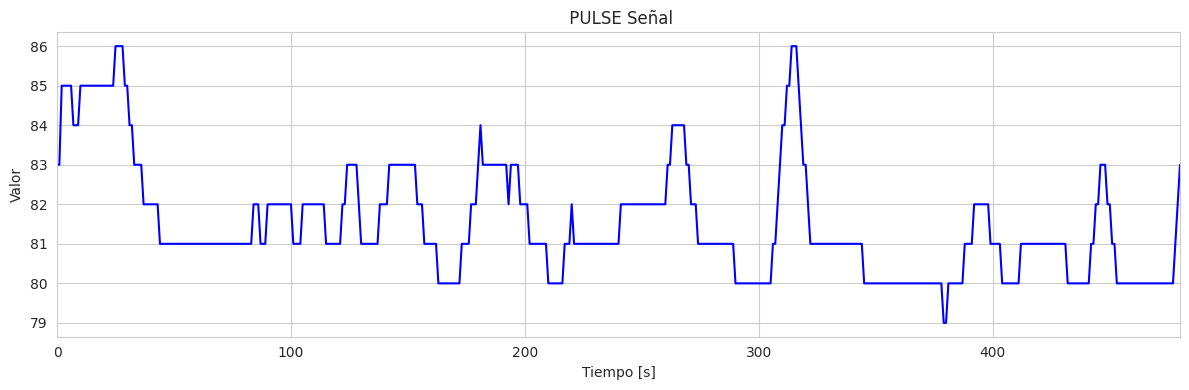

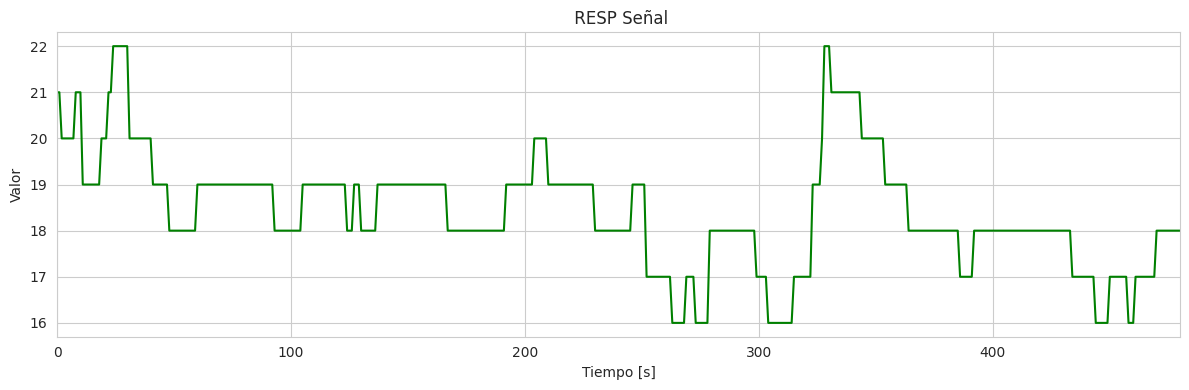

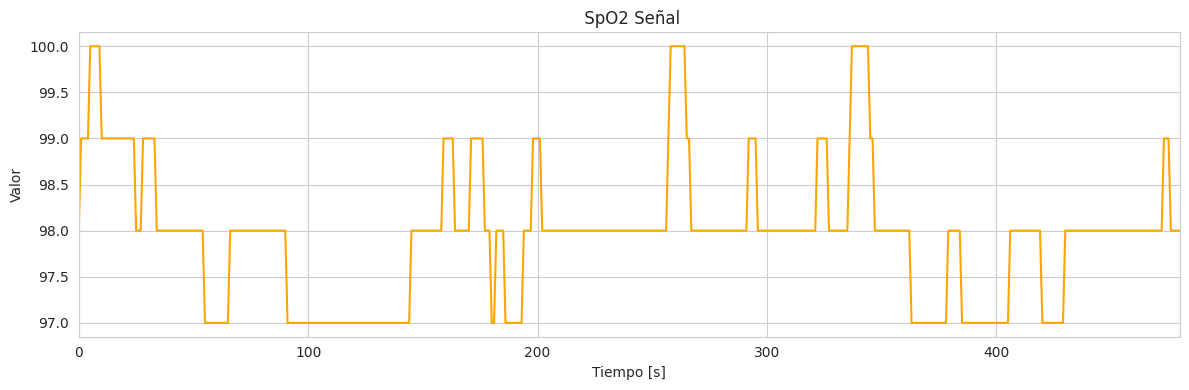


Descripción de los datos numéricos:
         Time [s]          HR       PULSE        RESP        SpO2
count  481.000000  481.000000  481.000000  481.000000  481.000000
mean   240.000000   82.145530   81.511435   18.413721   97.950104
std    138.997002    1.865148    1.440621    1.243876    0.734283
min      0.000000   79.000000   79.000000   16.000000   97.000000
25%    120.000000   81.000000   81.000000   18.000000   97.000000
50%    240.000000   82.000000   81.000000   18.000000   98.000000
75%    360.000000   83.000000   82.000000   19.000000   98.000000
max    480.000000   92.000000   86.000000   22.000000  100.000000

Visualización de las señales fisiológicas del paciente: 10



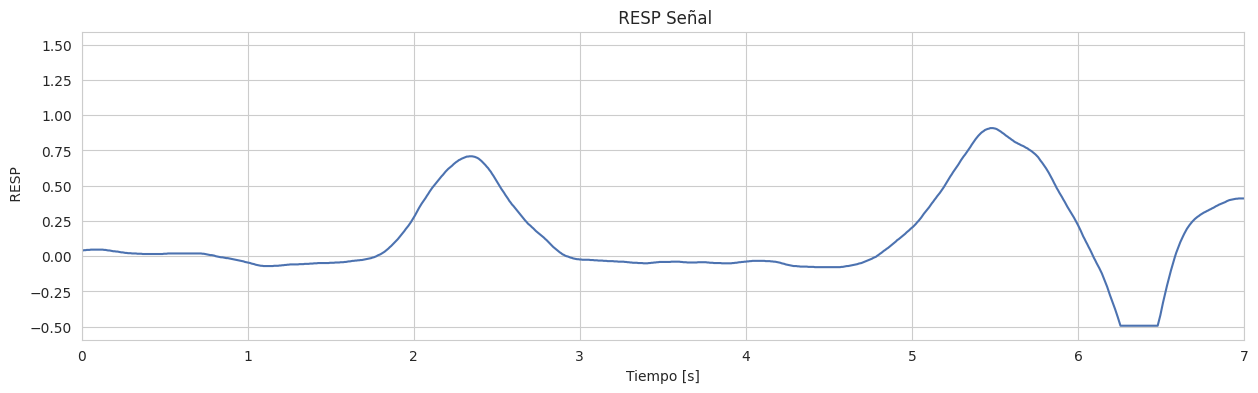

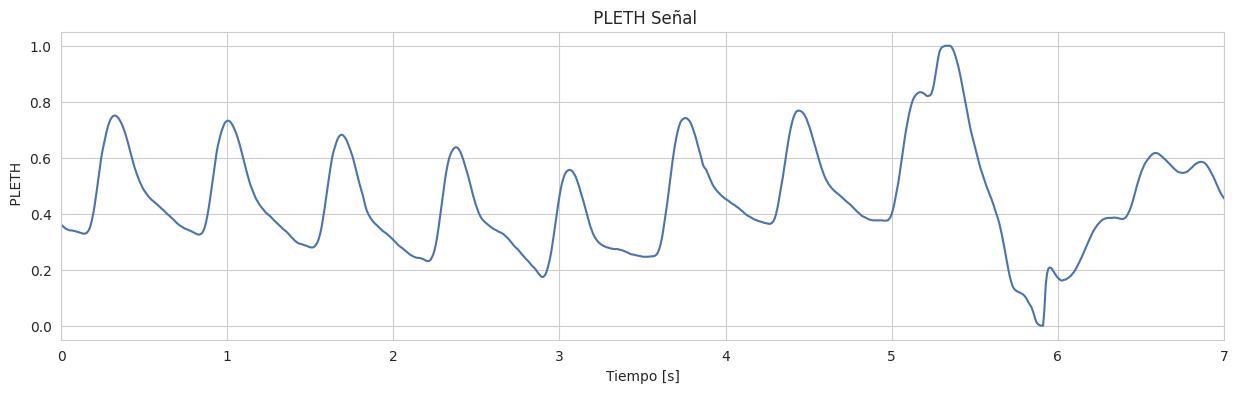

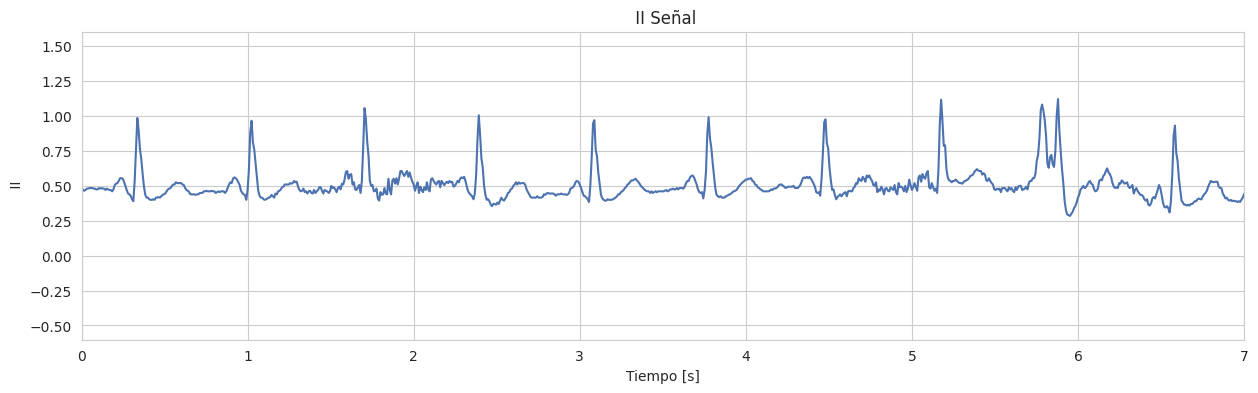

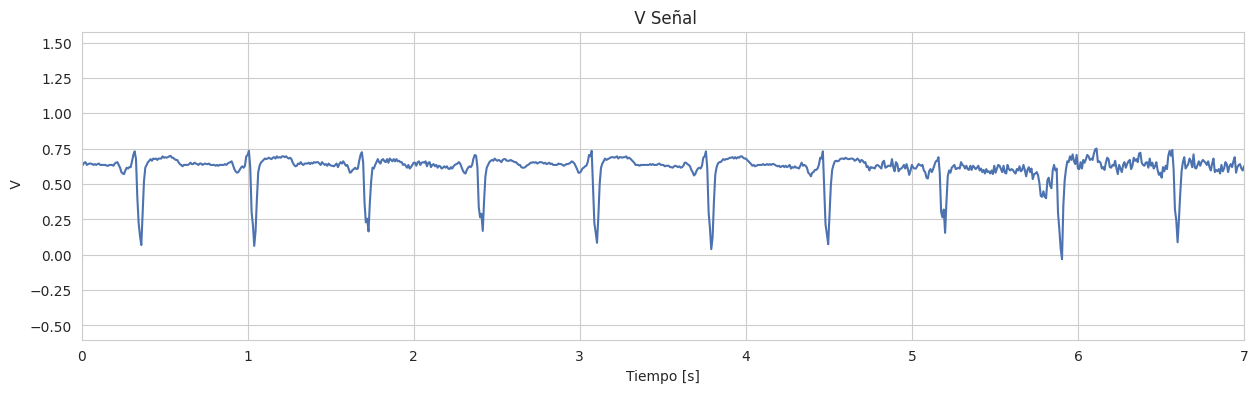

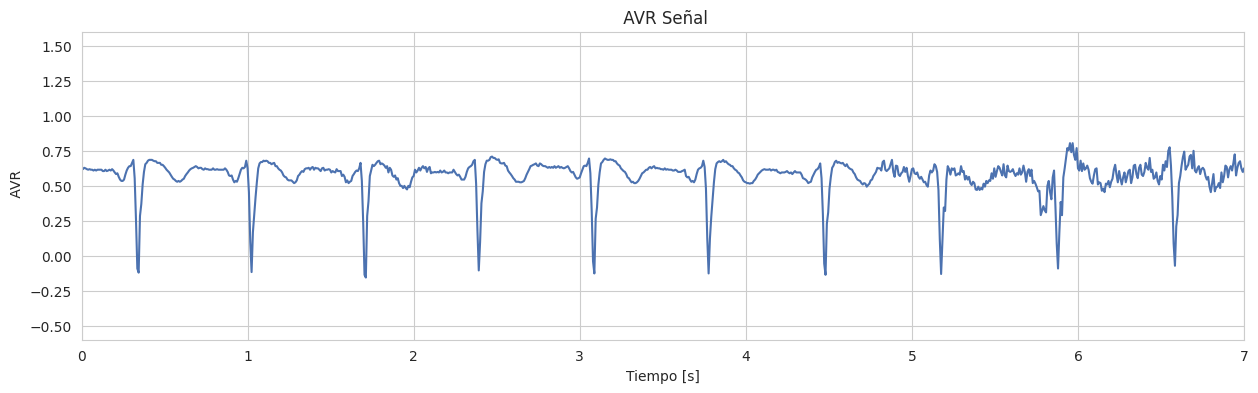

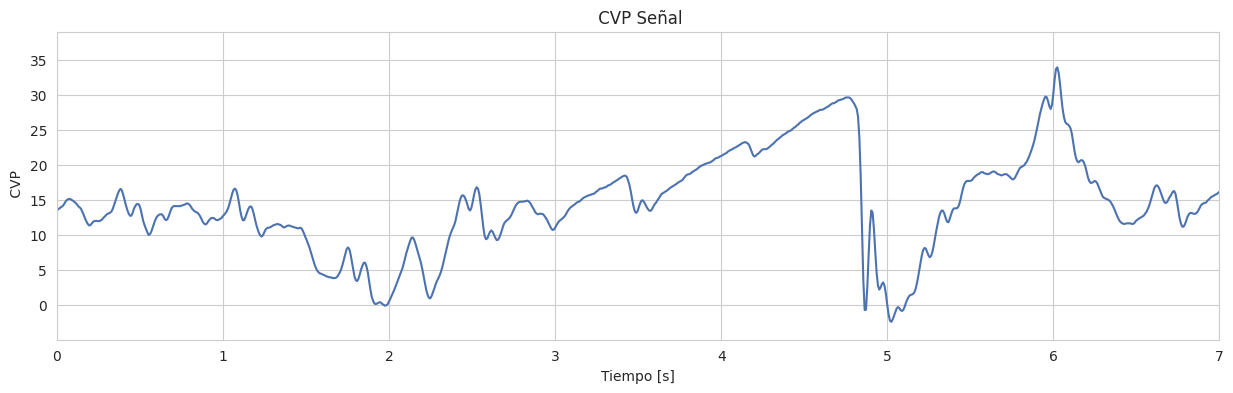




Descripción de las señales fisiológicas:
    Time [s]         RESP        PLETH           II            V          AVR          CVP
60001.000000 60001.000000 60001.000000 60001.000000 60001.000000 60001.000000 60001.000000
  240.000000     0.197611     0.444110     0.512560     0.613829     0.572924    12.560108
  138.567529     0.281873     0.160776     0.116617     0.103298     0.128608     5.051990
    0.000000    -0.493200     0.000000    -0.501960    -0.501960    -0.498050    -2.972600
  120.000000    -0.034951     0.323560     0.460780     0.615690     0.554690     9.934800
  240.000000     0.145630     0.406650     0.490200     0.629410     0.605470    12.634000
  360.000000     0.388350     0.565980     0.535290     0.654900     0.625000    14.628000
  480.000000     1.493200     1.000000     1.503900     1.478400     1.500000    37.040000


In [ ]:
patient_id = input("Ingrese el número del paciente: ")
patient_data = explore_and_visualize_patient_data(patient_id, directory)

##**Clasificación y diagnostico**

In [ ]:
# Resultados de clasificacion de resultados del conjunto
classification_results = process_patient_files(directory, 1)


-------------------------------------
Datos del paciente 01:
 * Edad: 88
 * Género: M
 * Promedio de variables fisiológicas:
   -> HR (Frecuencia Cardíaca): 91.32 = Rango normal
   -> PULSE (Pulso): 91.01 = Normal
   -> RESP (Respiración): 21.44 = Taquipnea (respiración rápida)
   -> SpO2 (Saturación de Oxígeno): 96.92 = Rango normal
Diagnóstico médico del paciente 01: HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal

-------------------------------------
Datos del paciente 02:
 * Edad: 65
 * Género: M
 * Promedio de variables fisiológicas:
   -> HR (Frecuencia Cardíaca): 91.07 = Rango normal
   -> PULSE (Pulso): 90.66 = Normal
   -> RESP (Respiración): 15.35 = Rango normal
   -> SpO2 (Saturación de Oxígeno): 99.99 = Rango normal
Diagnóstico médico del paciente 02: HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal

-------------------------------------
Datos del paciente 03:
 * Edad: 46
 * Género: F
 * Promedio de variables fisiol

In [ ]:
# Obtencion de datos de datos de cada paciente
patient_data = process_patient_files(directory, 2)


-------------------------------------
Datos del paciente 01:
 * Edad: 88
 * Género: M
 * Promedio de variables fisiológicas:
   -> HR (Frecuencia Cardíaca): 91.32 = Rango normal
   -> PULSE (Pulso): 91.01 = Normal
   -> RESP (Respiración): 21.44 = Taquipnea (respiración rápida)
   -> SpO2 (Saturación de Oxígeno): 96.92 = Rango normal
Diagnóstico médico del paciente 01: HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal

-------------------------------------
Datos del paciente 02:
 * Edad: 65
 * Género: M
 * Promedio de variables fisiológicas:
   -> HR (Frecuencia Cardíaca): 91.07 = Rango normal
   -> PULSE (Pulso): 90.66 = Normal
   -> RESP (Respiración): 15.35 = Rango normal
   -> SpO2 (Saturación de Oxígeno): 99.99 = Rango normal
Diagnóstico médico del paciente 02: HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal

-------------------------------------
Datos del paciente 03:
 * Edad: 46
 * Género: F
 * Promedio de variables fisiol

##**Visualización clasificación de pacientes por tipo de diagnóstico**

###**Diccionario de clasificaciones extraidas**

In [ ]:
print("Recuento de clasificaciones de pacientes:")
for classification, count in classification_results.items():
    print(f"{classification}: {count}")

Recuento de clasificaciones de pacientes:
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal: 5
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal: 33
HR:Rango normal, PULSE:Normal, RESP:Bradipnea (respiración lenta), SpO2:Rango normal: 3
HR:Taquicardia (ritmo cardíaco rápido), PULSE:Rapido, RESP:Rango normal, SpO2:Rango normal: 9
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre): 1
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre): 1


###**Visualizacion clasificacion**

In [ ]:
classification_df = pd.DataFrame({"Classification": list(classification_results.keys()), "Count": list(classification_results.values())})
fig = px.pie(classification_df, values='Count', names='Classification', title='Porcentaje de pacientes clasificados',
             labels={'Classification': 'Tipo'}, color='Classification', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

##**Visualización clasificación de pacientes por tipo de diagnóstico, edad y género**

In [ ]:
patient_ids = []
ages = []
genders = []
diagnosticos = []

for key, value in patient_data.items():
  patient_ids.append(key)
  ages.append(value['age'])
  genders.append(value['gender'])
  diagnosticos.append(physiological_data_analisis(value['Physiological Data']))

In [ ]:
df_g_a_d = pd.DataFrame({"Patient_id": patient_ids, "Age": ages, "Gender": genders, "Diagnostico": diagnosticos})

In [ ]:
valores_unicos = df_g_a_d['Diagnostico'].unique()
recuento = df_g_a_d['Diagnostico'].value_counts()
recuento

Diagnostico
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal                                                           33
HR:Taquicardia (ritmo cardíaco rápido), PULSE:Rapido, RESP:Rango normal, SpO2:Rango normal                                     9
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal                                          5
HR:Rango normal, PULSE:Normal, RESP:Bradipnea (respiración lenta), SpO2:Rango normal                                           3
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre)     1
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre)                       1
Name: count, dtype: int64

In [ ]:
mapeo_diagnosticos = {diagnostico: i for i, diagnostico in enumerate(valores_unicos.tolist())}
df_g_a_d['Numero_Diagnostico'] = df_g_a_d['Diagnostico'].map(mapeo_diagnosticos)
df_g_a_d

,Patient_id,Age,Gender,Diagnostico,Numero_Diagnostico
0,01,88,M,"HR:Rango normal, PULSE:Normal, RESP:Taquipnea ...",0
1,02,65,M,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
2,03,46,F,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
3,04,78,M,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
4,05,73,F,"HR:Rango normal, PULSE:Normal, RESP:Bradipnea ...",2
5,06,64,F,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
6,07,64,F,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
7,08,64,F,"HR:Rango normal, PULSE:Normal, RESP:Taquipnea ...",0
8,09,64,F,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1
9,10,74,M,"HR:Rango normal, PULSE:Normal, RESP:Rango norm...",1


In [ ]:
diagnosticos_indicadores = df_g_a_d[['Diagnostico', 'Numero_Diagnostico']].drop_duplicates().set_index('Diagnostico')['Numero_Diagnostico'].to_dict()
print("Diagnosticos y numero ID")
for diagnostico, indicador in diagnosticos_indicadores.items():
    print(f"{diagnostico}: {indicador}")

Diagnosticos y numero ID
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal: 0
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal: 1
HR:Rango normal, PULSE:Normal, RESP:Bradipnea (respiración lenta), SpO2:Rango normal: 2
HR:Taquicardia (ritmo cardíaco rápido), PULSE:Rapido, RESP:Rango normal, SpO2:Rango normal: 3
HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre): 4
HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre): 5


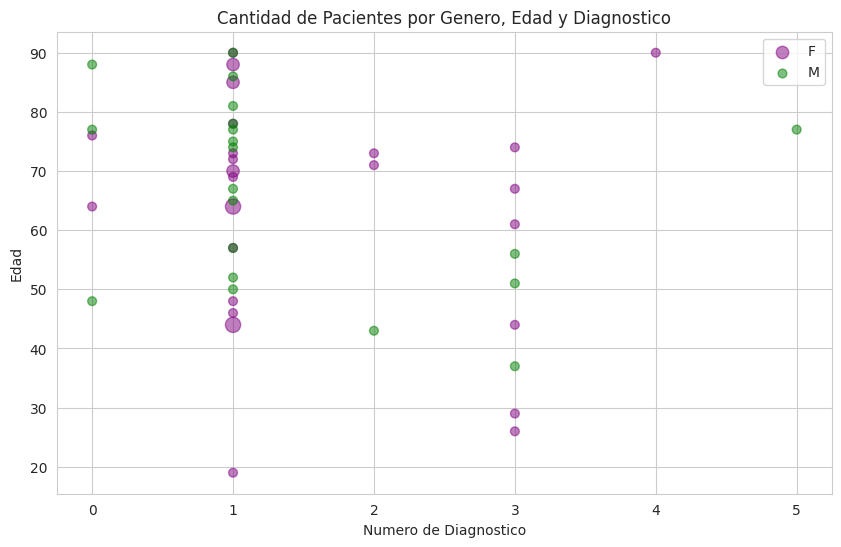

In [ ]:
grouped_df = df_g_a_d.groupby(['Gender', 'Age', 'Numero_Diagnostico']).size().reset_index(name='Cantidad')
colors = {'M': 'green', 'F': 'purple'}
plt.figure(figsize=(10, 6))
for gender, data in grouped_df.groupby('Gender'):
    plt.scatter(data['Numero_Diagnostico'], data['Age'], s=data['Cantidad']*40, c=colors[gender], alpha=0.5, label=gender)
plt.xlabel('Numero de Diagnostico')
plt.ylabel('Edad')
plt.title('Cantidad de Pacientes por Genero, Edad y Diagnostico')
plt.legend()
plt.show()

#**Visualización interfaz gráfica**

###**Visualización clasificación de pacientes por tipo de diagnósitco del conjunto de datos**

In [ ]:
carpeta = "/content/html_data"
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

In [ ]:
html_content = clasificacion_html(classification_results)
with open("/content/html_data/classification_data.html", "w") as file:
    file.write(html_content)

In [ ]:
HTML(html_content)

"HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Rango normal",5
"HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Rango normal",33
"HR:Rango normal, PULSE:Normal, RESP:Bradipnea (respiración lenta), SpO2:Rango normal",3
"HR:Taquicardia (ritmo cardíaco rápido), PULSE:Rapido, RESP:Rango normal, SpO2:Rango normal",9
"HR:Rango normal, PULSE:Normal, RESP:Taquipnea (respiración rápida), SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre)",1
"HR:Rango normal, PULSE:Normal, RESP:Rango normal, SpO2:Hipoxemia (niveles bajos de oxígeno en la sangre)",1


###**Interfaz información de los pacientes por id**

In [ ]:
HTML(gen_patient_id_html(patient_data))

Ingrese el número del paciente: 02
